<a href="https://colab.research.google.com/github/ParthikB/siamese/blob/master/siamese_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import seaborn as sns

%matplotlib inline

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


In [2]:
train_data = datasets.CIFAR100('/content/', train=True, download=True,
                      transform=transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]))

test_data  = datasets.CIFAR100('/content/', train=False, download=True,
                      transform=transforms.Compose([transforms.Grayscale(), transforms.ToTensor()]))

BATCH_SIZE = 64
CLASSES    = 100

trainSet = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
testSet  = torch.utils.data.DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False)

Extracting /content/cifar-100-python.tar.gz to /content/
Files already downloaded and verified


Batch Size : 64
torch.Size([1, 32, 32])
tensor(84)


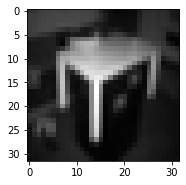

In [3]:
i = np.random.randint(BATCH_SIZE) # a random sample from the first batch
for batch in trainSet:
    print("Batch Size :", len(batch[0]))
    # batch --> one batch containing BATCH_SIZE samples
    x, y = batch[0][i], batch[1][i]
    break

CHANNELS, DIM, DIM = x.shape
TOTAL_PIXELS = DIM*DIM
print(x.shape)

plt.subplot(1, 2, 1)
plt.imshow(x.view(DIM, DIM), cmap='gray') # Reshaping x from (1, DIM, DIM) --> (DIM, DIM)
print(y)

In [0]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    '''
    Network Structure:

    input > 
    (1)Conv2D > (2)MaxPool2D > 
    (3)Conv2D > (4)MaxPool2D > 
    (5)Conv2D > (6)MaxPool2D > 
    (7)Linear > (8)LinearOut

    '''

    # Creating the convulutional Layers
    self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=32, kernel_size=3)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

    self.flatten = None
    # Creating a Random dummy sample to get the Flattened Dimensions
    x = torch.randn(CHANNELS, DIM, DIM).view(-1, CHANNELS, DIM, DIM)
    x = self.convs(x)

    # Creating the Linear Layers
    self.fc1   = nn.Linear(self.flatten, TOTAL_PIXELS)
    self.fc2   = nn.Linear(TOTAL_PIXELS, CLASSES)

  def convs(self, x):
    # Creating the MaxPooling Layers
    x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), kernel_size=(2, 2))

    if not self.flatten:
      self.flatten = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x

  # FORWARD PASS
  def forward(self, x):

    x = self.convs(x)
    x = x.view(-1, self.flatten)
    sm = F.relu(self.fc1(x))
    # x = F.softmax(self.fc2(sm), dim=1)
    x = self.fc2(sm)

    return x, sm

In [0]:
def train(net, train_set, loss_log=[], EPOCHS=5, LEARNING_RATE=0.001, BATCH_SIZE=32):
  print('Initiating Training..')  
  loss_func = nn.CrossEntropyLoss()

  # Iteration Begins
  for epoch in tqdm_notebook(range(EPOCHS)):
    # Iterate over every sample in the batch
    for data in tqdm_notebook(trainSet, desc=f'Iteration > {epoch+1}/{EPOCHS} : ', leave=False):
        x, y = data
        net.zero_grad()
        
        #Compute the output
        output, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))
        
        # Compute Loss
        loss = loss_func(output, y.to(device))
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
 
    loss_log.append(loss)
  
  return loss_log



def test(net, test_set, find_accuracy=True):
  print('Initiating Testing..')
  correct = 0
  total   = 0
  accuracy = 0
  sm_log = []

  with torch.no_grad():
    for data in tqdm_notebook(test_set):
      x, y = data

      # Prediction the TestSet Data
      prediction_in_batch, sm = net(x.view(-1, CHANNELS, DIM, DIM).to(device))

      # ARGMAXing the predicted output
      for output in zip(prediction_in_batch, y, sm):
        pred_class, real_class, sm = output
        pred_class = torch.argmax(pred_class)

        sm_log.append([sm, real_class])

        if find_accuracy:
          total += 1
          if real_class == pred_class:
            correct += 1

  if find_accuracy:
    accuracy = (correct/total)*100
    print()
    print(f'Test Accuracy : {round(accuracy, 2)} %')
  
  return accuracy, sm_log

Initiating Training..


Initiating Testing..



Test Accuracy : 24.56 %
Total Epochs : 10


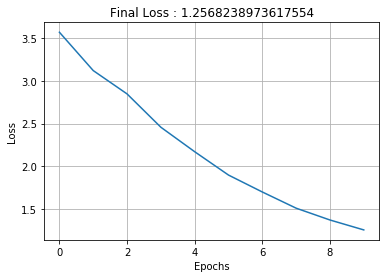

In [7]:
EPOCHS        = 10
LEARNING_RATE = 0.001
BATCH_SIZE    = BATCH_SIZE
CONTINUE_TRAINING = 0

if not CONTINUE_TRAINING:
  net = Net().to(device)
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []
  total_epochs = 0


total_epochs += EPOCHS
loss_log = train(net, trainSet, loss_log, EPOCHS, LEARNING_RATE, BATCH_SIZE)

plt.plot(loss_log)
plt.grid(1)
plt.title(f'Final Loss : {loss_log[-1]}')
plt.xlabel('Epochs')
plt.ylabel('Loss')

accuracy, sm_log = test(net, testSet)

print(f'Total Epochs : {total_epochs}')

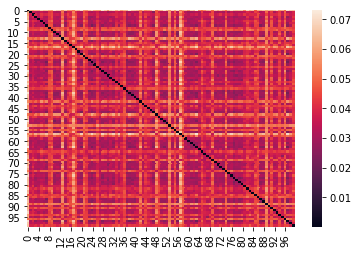

In [8]:
def mean(list):
  return sum(list)/len(list)

# CREATING A DICT THAT CONTAINS THE RESPECTIVE SM
classes = {}

for data in (sm_log):
  sm, label = data
  label = label.numpy()
  sm = sm.cpu().numpy()
  
  try:
    classes[str(label)].append(sm)
  except:
    classes[str(label)] = [sm]


# FINDING THE MINIMUM SAMPLES to CLIP
clip = 1000
for i in classes.keys():
  clip = min(clip, len(classes[i]))


# CLIPPING ALL THE CLASSES SAMPLES TO THE MINIMUM
for i in classes.keys():
  classes[i] = classes[i][:clip]

# CREATING A MASTER IN ORDER
master = []
for c in sorted(classes.keys()):
  master.append(np.array(classes[c]))

# CREATING A MAP LIST TO PLOT
edist_log=[]
for class1 in master:
  class1 = torch.Tensor(class1.mean(axis=1))
  for class2 in master:
    class2 = torch.Tensor(class2.mean(axis=1))
    edist = F.pairwise_distance(class1.view(-1,  1), class2.view(-1,  1), keepdim = True).float().numpy()
    edist_log.append(edist.mean())

plot_dim = int(np.sqrt(np.array(len(edist_log))))

map = np.array(edist_log).reshape(plot_dim, plot_dim)
sns.heatmap(map)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Image Original Dimensions : (458, 620)
Image Resized Dimensions  : (448, 608)


Text(0.5, 1.0, 'VIS Image')

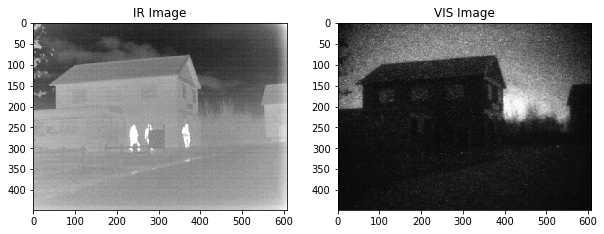

In [53]:
from PIL import Image
import cv2 

def resize_image(img, row, col, slice):
  return cv2.resize(img, (col-col%slice, row-row%slice))


SLICE = 32

ir = plt.imread('/content/drive/My Drive/Colab Notebooks/siamese_paper/dataset/IR.bmp')
vis = plt.imread('/content/drive/My Drive/Colab Notebooks/siamese_paper/dataset/VIS.bmp')

row, col = ir.shape
print('Image Original Dimensions :', ir.shape)

ir  = resize_image(ir,  row, col, slice=SLICE)
vis = resize_image(vis, row, col, slice=SLICE)

print('Image Resized Dimensions  :', ir.shape)
ROW, COL = ir.shape

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(ir, cmap='gray')
plt.title('IR Image')

plt.subplot(1, 2, 2)
plt.imshow(vis, cmap='gray')
plt.title('VIS Image')

Total Slices : 266
Total Slices : 266


Text(0.5, 1.0, 'VIS Slice')

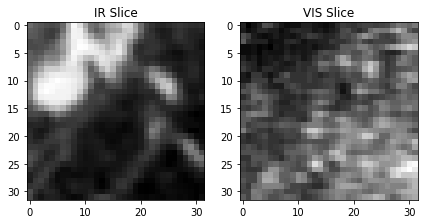

In [33]:
# Getting a single slice according to the current coordinates
def get_slice(img, start_row, end_row, start_col, end_col):
  return img[start_row:end_row, start_col:end_col]

# Dividing the Image into smaller slices
def get_slice_list(img, slice_size):
  
  w, h = img.shape
  nw, nh = w//slice_size, h//slice_size

  slices = []
  for i in range(nw):
    for j in range(nh):
      start_row = 32*i 
      start_col = 32*j
      end_row   = start_row + 32 
      end_col   = start_col + 32

      # print(start_row, end_row, start_col, end_col) 

      slice = get_slice(img, start_row, end_row, start_col, end_col)
      slices.append(slice)
      
  print(f'Total Slices : {len(slices)}')  
  return slices


# Dividing into respective slices
ir_slices  = get_slice_list(ir, SLICE)
vis_slices = get_slice_list(vis, SLICE)


# Visualizing a random slice
SLICE_NUMBER = 0

plt.figure(figsize=(7, 7))

plt.subplot(1, 2, 1)
plt.imshow(ir_slices[SLICE_NUMBER], cmap='gray')
plt.title('IR Slice')

plt.subplot(1, 2, 2)
plt.imshow(vis_slices[SLICE_NUMBER], cmap='gray')
plt.title('VIS Slice')

In [0]:
# Creating the slice dataset to be fed into the Network
def create_slice_dataset(slice_type):
  slice_dataset = []
  for data in slice_type:
    slice = torch.Tensor(np.expand_dims(data, 0))
    slice_dataset.append([slice, 'null'])
  
  return slice_dataset

ir_dataset  = create_slice_dataset(ir_slices)
vis_dataset = create_slice_dataset(vis_slices)

In [34]:
# Feeding the dataset(s) to the Network -> returns the Siamese Layer
_, ir_slice_sm  = test(net, ir_dataset, find_accuracy=False)
_, vis_slice_sm = test(net, vis_dataset, find_accuracy=False)

# Filtering the output / getting rid of unwanted outputs
def remove_class_type_from_log(log):
  for i in range(len(log)):
    log[i] = log[i][0].cpu().float()
  return log

ir_slice_sm  = remove_class_type_from_log(ir_slice_sm)
vis_slice_sm = remove_class_type_from_log(vis_slice_sm)

Initiating Testing..


Initiating Testing..


Text(0.5, 1.0, 'VIS Slice')

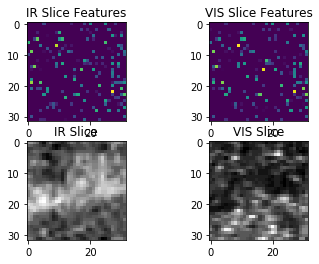

In [47]:
SLICE_NUMBER = 200

plt.subplot(2, 2, 1)
plt.imshow(ir_slice_sm[SLICE_NUMBER].reshape(32, 32))
plt.title('IR Slice Features')

plt.subplot(2, 2, 2)
plt.imshow(vis_slice_sm[SLICE_NUMBER].reshape(32, 32))
plt.title('VIS Slice Features')

plt.subplot(2, 2, 3)
plt.imshow(ir_slices[SLICE_NUMBER], cmap='gray')
plt.title('IR Slice')

plt.subplot(2, 2, 4)
plt.imshow(vis_slices[SLICE_NUMBER], cmap='gray')
plt.title('VIS Slice')

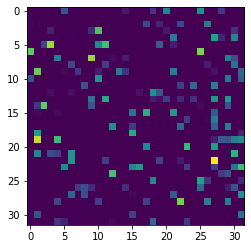

In [50]:
def get_sim_score(img1, img2):
    return F.pairwise_distance(img1.view(-1,  1), img2.view(-1,  1), keepdim=True).float().numpy()

# Getting the Euclidian Distance
edist = get_sim_score(ir_slice_sm[SLICE_NUMBER], vis_slice_sm[SLICE_NUMBER])

plt.imshow(edist.reshape(32, 32))

In [0]:
sim_score_arr = []
for SLICE_NUMBER in range(len(ir_slice_sm)):
  edist = get_sim_score(ir_slice_sm[SLICE_NUMBER], vis_slice_sm[SLICE_NUMBER])
  # print(np.sum(edist.reshape(32, 32)))
  sim_score_arr.append(edist.reshape(32, 32))

In [0]:
def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

In [56]:
weight_map = unblockshaped(np.array(sim_score_arr), ROW, COL)
vis_img    = unblockshaped(np.array(vis_slices), ROW, COL)
ir_img     = unblockshaped(np.array(ir_slices), ROW, COL)

print('Reconstructed figure dimensions :', weight_map.shape)

# Normalizing the weight map under range(0, 1)
norm_weight = weight_map
norm_weight *= 255.0/weight_map.max()
norm_weight /= 255.0

Reconstructed figure dimensions : (448, 608)


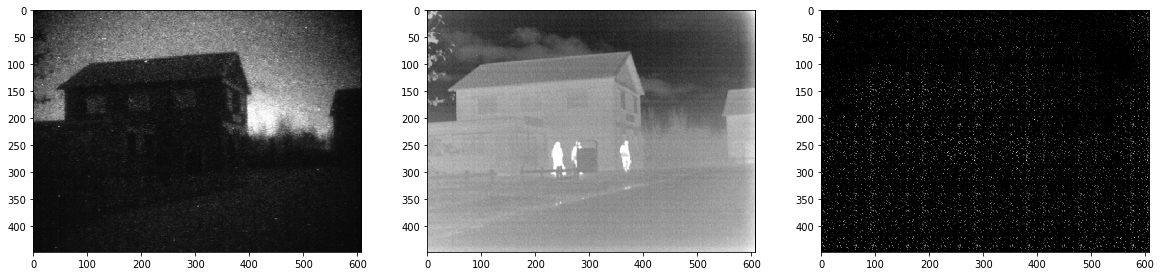

In [57]:
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.imshow(vis_img, cmap='gray')

plt.subplot(1, 3, 2)
plt.imshow(ir_img, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(norm_weight/255.0, cmap='gray')

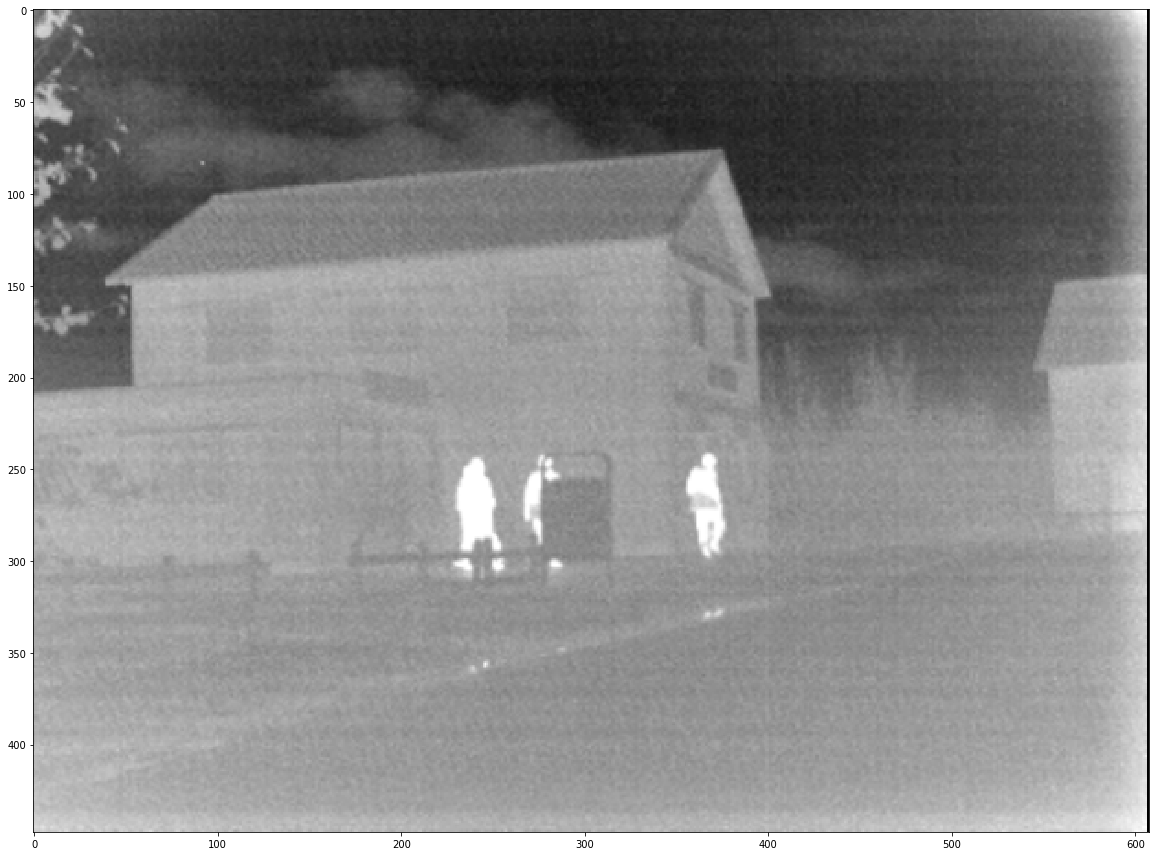

In [65]:
def fuse(weight_map, vis, ir):
  fuse = (weight_map * vis) + ((1-weight_map) * ir)
  return fuse

fused_image = fuse(weight_map, vis_img, ir_img)

plt.figure(figsize=(20, 20))
# plt.imshow(fuse(norm_weight/255.0, ir_img ,vis_img), cmap='gray')
plt.imshow(fuse(norm_weight/255.0, vis_img, ir_img), cmap='gray')